In [1]:
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from pathlib import Path

from fastai.callbacks.hooks import *
from fastai.utils.mem import *

# Getting the data

In [4]:
BaseFolder = Path.cwd()
DataFolder = BaseFolder/'Data'

In [5]:
DataFolder.mkdir(parents=True, exist_ok=True)
DataFolder

PosixPath('/home/jupyter/RetinaProject/Data')

In [6]:
DataFolder.as_posix()

'/home/jupyter/RetinaProject/Data'

In [7]:
DataFolder.cwd()

PosixPath('/home/jupyter/RetinaProject')

The data is on https://drive.grand-challenge.org/Download/. First you need to sign in and join. 
Then, in Chrome "More tools", go to "developer mode". Click on the link in the regular webpage. In the developer mode pane, right click on the file, and select copy cURL (bash). 

in cmd:
$ wsl \{whatever is copied\} -O -J
The -O to keep remote filenme.
The -J to preserve headers. 

In [8]:
## For Linux:
! (cd {DataFolder.as_posix()} && curl 'https://grand-challenge.org/media/drive/datasets/training.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J)
! (cd {DataFolder.as_posix()} && curl 'https://grand-challenge.org/media/drive/datasets/test.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.0M  100 14.0M    0     0  5495k      0  0:00:02  0:00:02 --:--:-- 5493k
curl: Saved to filename 'training.zip'
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.8M  100 13.8M    0     0  5129k      0  0:00:02  0:00:02 --:--:-- 5127k
curl: Saved to filename 'test.zip'


In [15]:
## For Linux:
# if not previously installed: $ sudo apt-get install p7zip-full
! for x in *.zip; do 7z x $x; done


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /home/jupyter/RetinaProject/Data/                                           1 file, 14571523 bytes (14 MiB)

Extracting archive: /home/jupyter/RetinaProject/Data/test.zip
--
Path = /home/jupyter/RetinaProject/Data/test.zip
Type = zip
Physical Size = 14571523


No files to process
Everything is Ok

Files: 0
Size:       0
Compressed: 14571523


# data loading

In [7]:
TrainingDataFolder = DataFolder/'training'/'images'
SegmentationMasksFolder = DataFolder/'training'/'1st_manual'

In [8]:
fnames = get_image_files(TrainingDataFolder)
fnames[:3]

[PosixPath('/home/jupyter/RetinaProject/Data/training/images/35_training.tif'),
 PosixPath('/home/jupyter/RetinaProject/Data/training/images/24_training.tif'),
 PosixPath('/home/jupyter/RetinaProject/Data/training/images/32_training.tif')]

In [9]:
lbl_names = get_image_files(TrainingDataFolder)
lbl_names[:3]

[PosixPath('/home/jupyter/RetinaProject/Data/training/images/35_training.tif'),
 PosixPath('/home/jupyter/RetinaProject/Data/training/images/24_training.tif'),
 PosixPath('/home/jupyter/RetinaProject/Data/training/images/32_training.tif')]

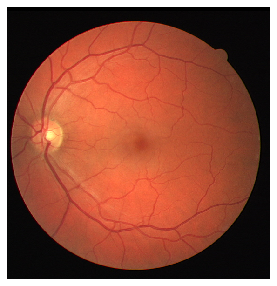

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
def get_y_fn(path):
    """Get the path of the segmented training file for the path of an original image. \n
    
    Keyword arguments:
    path -- a pathlib Path to the original data image.
    
    Output
    SegmentedMaskPath -- a pathlib Path to the matching segmeneted training image. 
    """
    x = path
    SegmentedTrainnigShortFilename = x.stem.replace('training', 'manual1')+ '.gif'
    SegmentedMaskPath = SegmentationMasksFolder/SegmentedTrainnigShortFilename
    return SegmentedMaskPath

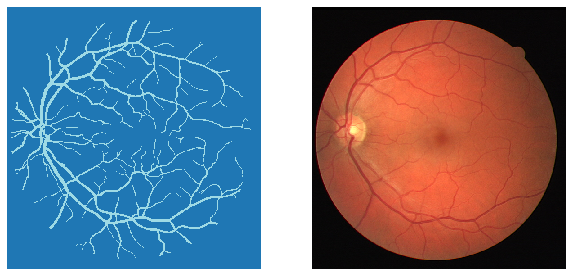

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
mask = open_mask(get_y_fn(img_f))
mask.show(alpha=1, ax= ax[0])
img.show(ax= ax[1])

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([584, 565]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [14]:
N_of_Codes = len(np.unique(mask.data))
N_of_Codes

2

In [15]:
codes = ['No', 'Yes']

## Playing with Transformations

In [16]:
def plots_f(exImage, rows, cols, width, height, **kwargs):
    [exImage.apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

In [18]:
# defaults:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10.0, 
               max_zoom=1.1, max_lighting=0.2, max_warp=0.2, 
               p_affine=0.75, p_lighting=0.75)

In [19]:
# defaults:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=80.0, 
               max_zoom=1.1, max_lighting=0.2, max_warp=0.2, 
               p_affine=0.75, p_lighting=0.75)

In [19]:
tfms = ([],[])

### failed atttempts to cancel the reflection mode, and change to border .

In [22]:
tfmsModPadBrdr = [RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 
                                                                'padding_mode': 'border'}, 
                                p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
                  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, 
                                is_random=True, use_on_y=True),
                  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, 
                                do_run=True, is_random=True, use_on_y=True),
                  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90.0, 90.0)}, p=0.75, resolved={}, 
                                do_run=True, is_random=True, use_on_y=True),
                  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, 
                                p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
                  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, 
                                do_run=True, is_random=True, use_on_y=True),
                  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, 
                                do_run=True, is_random=True, use_on_y=True)]

In [ ]:
# In lesson7-resnet-mnist Jeremy used this on the labellists (src)! Problem, no = for transform here. Always. 
tfms = ([*rand_pad(padding=3, size=size, mode='zeros')], [])
data = (src.transform(tfms, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
# tfms = ([*rand_pad(padding=3, size=size, mode='zeros')], [])
# src.transform(tfms)

try https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai. But: not a U-net, so the prediction (validation) probably did not have the same transformation as the imput in this solution. 

Promising: 
and https://alexiej.github.io/deepnn/#list-of-transforms
Check if I can do this , it should work for validation data out of the box. 

## Datasets

In [17]:
# an insert to make fastai change classes to 0,1 which it can cope with 
# https://forums.fast.ai/t/cant-do-segmentation-cuda-error-device-side-assert-triggered/37507/4
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [17]:
# del learn

In [104]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [105]:
del learn

In [106]:
gc.collect()

40

In [18]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")
print('Consider deleting learners and collcting gc before starting. ')

using bs=4, have 11430MB of GPU RAM free
Consider deleting learners and collcting gc before starting. 


In [19]:
# create label-list from datafiles. change SegmentationItemList to SegItemListCustom 
src = (SegItemListCustom. 
       from_folder(TrainingDataFolder).
       split_by_rand_pct(seed=42).
       label_from_func(get_y_fn, classes=codes))

In [20]:
# data = (src.transform(tfms, size=size, tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))
# Here we need to use tfm_y=True in the transform call because we need the same 
# transforms to be applied to the target mask as were applied to the image. 

In [21]:
data = (src.transform(tfms=[[],[]])
        .databunch(bs=bs)
        .normalize(imagenet_stats))
# Here we need to use tfm_y=True in the transform call because we need the same 
# transforms to be applied to the target mask as were applied to the image. 

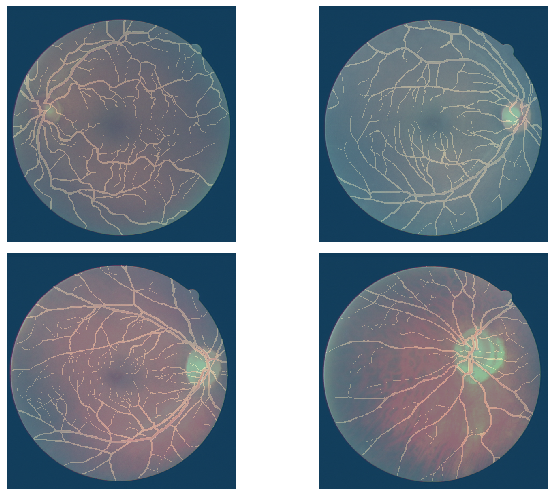

In [22]:
data.show_batch(3, figsize=(10,7), alpha = 0.5)

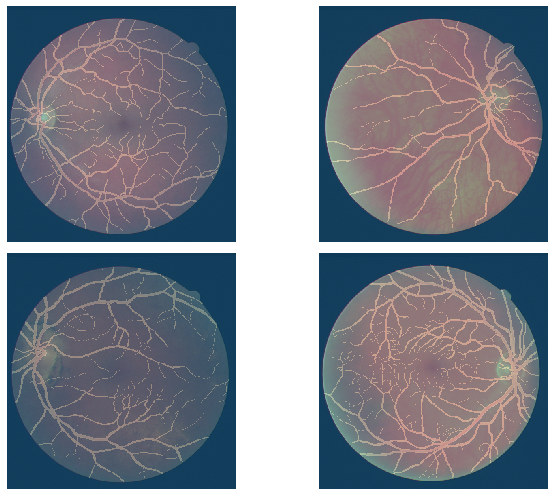

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid, alpha= 0.5)

In [24]:
data.classes

['No', 'Yes']

# Model

In [25]:
def acc_retina(prediction, target):
    # average fraction of correct predictions. 
    target = target.squeeze(1)
    return (prediction.argmax(dim=1)==target).float().mean()


def acc_camvid(input, target): # original in camvid lesson
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [26]:
metrics=acc_retina
# metrics=accuracy

In [27]:
wd=1e-2

In [28]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [37]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [33]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(20, slice(lr), pct_start=0.9)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr()

In [64]:
learn.save('stage-1')

In [29]:
learn.load('stage-1');

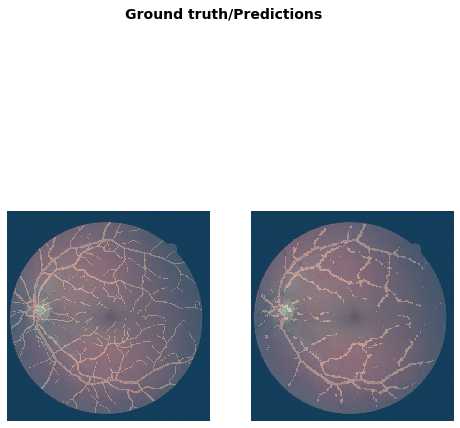

In [30]:
learn.show_results(rows=1, figsize=(8,9), alpha = 0.5)

In [31]:
learn.unfreeze()

In [34]:
lrs = slice(lr/400,lr/6)

In [35]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_retina,time
0,0.151375,0.150644,0.943334,00:27
1,0.151013,0.149818,0.943861,00:12
2,0.150752,0.149199,0.944183,00:12
3,0.150526,0.148944,0.944101,00:12
4,0.150027,0.147276,0.944926,00:12
5,0.149336,0.146961,0.944892,00:12
6,0.148784,0.145084,0.945794,00:12
7,0.147936,0.144211,0.946218,00:12
8,0.147436,0.144266,0.946369,00:12
9,0.146704,0.146021,0.945924,00:12


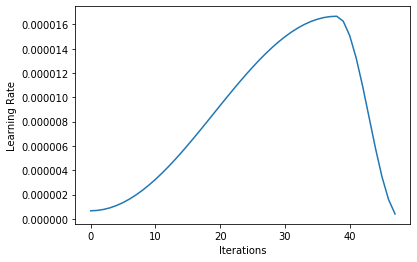

In [36]:
learn.recorder.plot_lr()

In [37]:
learn.save('stage-2-Unfreeze-lr_6');

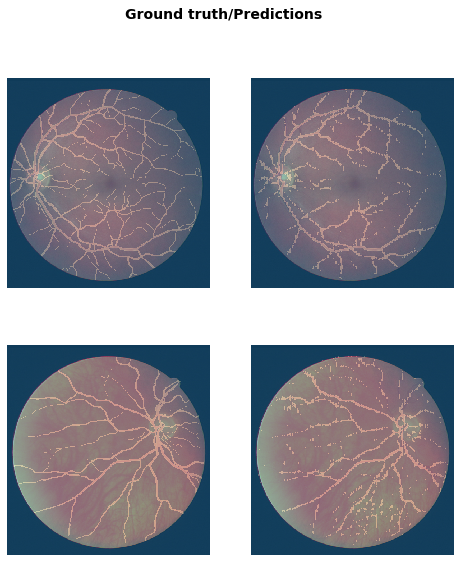

In [38]:
learn.show_results(rows=2, figsize=(8,9), alpha = 0.5)

In [48]:
learn.load('stage-2-Unfreeze-lr_6');

In [49]:
lrs = slice(lr/1600,lr/16)

In [50]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_retina,time
0,0.145135,0.149198,0.944896,00:12
1,0.145152,0.149542,0.944850,00:12
2,0.145330,0.150267,0.944659,00:12
3,0.145635,0.151364,0.944198,00:12
4,0.146246,0.154131,0.943425,00:12


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_lr()

### SHOW against the training data!!!

In [ ]:
# def VisCheckTrainRestuls(N_rows):
    
ind = 2
fig, ax = plt.subplots(1,2, figsize = (10,10))
train_target = learn.data.train_ds[ind][1]
train_result = learn.predict(learn.data.train_ds[ind][0])[0]
train_result.show(ax = ax[0])
train_target.show(ax = ax[1])

# some tricks

In [ ]:
https://forums.fast.ai/t/calculating-the-accuracy-for-test-set/39360/3

Here is my code:

main data set to train the model (train, valid ):
bs = 64
np.random.seed(42)
path = Path(‘train’).resolve()
data = (ImageItemList.from_folder(path)
.random_split_by_pct(valid_pct=0.2)
.label_from_folder()
.transform(size=224)
.databunch(bs=bs)).normalize(imagenet_stats)

and when I finished training the model I used:
2. test set

path = Path().resolve()
data_test = (ImageItemList.from_folder(path)
.split_by_folder(train=‘train’, valid=‘test’)
.label_from_folder()
.transform( size=224)
.databunch(bs=bs)).normalize(imagenet_stats)

step to validate the test set:
learn.validate(data_test.valid_dl)

step to show the top losses and condusion matrix (the problem):
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data_test.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

it gives the confusion of the real validation data even I wrote ‘data_test.valid_ds’, not ‘data.valid_ds’.

I hope you will get my point and can help me fix it.

It‘s probably because you use. ClassificationInterpretation.from_learner() and pass it the learner you used for training, which contains the original Val set. Try to save the Model, create a new learner with your second databunch and reload the weights, then do the Interpretation.

